<a href="https://colab.research.google.com/github/ClarisseAlvarenga/maratona_btc_desafio_7/blob/master/TNT_no_Pycaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TESTANDO O NOTEBOOK DE EXEMPLO DE CLASSIFICAÇÃO DO PYCARET NO DATASET DA TNT
This notebook is created using PyCaret 2.0. Last updated : 31-07-2020

In [ ]:
# instalação das libs
#!pip install cloudant
!pip install pycaret==2.0

In [1]:
# check version
from pycaret.utils import version
version()

2.0


In [2]:
#importando meu arquivo com senhas
import senhas
#importando a função com as minhas senhas
from senhas import senhas
#username, password e account 
u, p, a = senhas()

# 1. Data Repository

In [3]:
#importar o cloudant e o pandas
from cloudant import Cloudant #para leitura do DB criado na IBM
import pandas as pd #para manipulação de dados
#cria o cliente com um objeto Cloudant
client = Cloudant(cloudant_user=u,auth_token=p, account=a, connect=True, auto_renew=True)
#conexão com o banco de dados
db = client['clarisse-tnt']
response = db.all_docs(limit=100000, include_docs=True)
docs = [] 
for r in response['rows']: 
  docs.append(r['doc']) 
  type(docs)

In [4]:
#criando o Dataframe
df = pd.DataFrame(data=docs) 
#alterando as colunas latitude e longitude para float
df[['LAT', 'LONG']] = df[['LAT', 'LONG']].astype(float) 
#criando uma lista com as features que eu quero transformar para int64
colunas_int = ['Movimentação','Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina','Citrus', 'Açaí-Guaraná', 'Pêssego', 'row']
#convertendo as colunas para int
df[colunas_int] = df[colunas_int].astype(int)

In [5]:
#criando uma cópia do dataset original 
dados = df.copy()
#convertendo as colunas de object para string
dados = dados.drop_duplicates(subset=['row']).copy()
dados.shape

(15880, 17)

In [6]:
#visualizando a base inicial
dados.head()

,_id,_rev,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,row
0,000ac62b7850525df9febd4a670ff22e,1-904f48fde3c9b9ff27c4fe288e0c8d78,2018-5-28,Trianon-Masp,-23.5634,-46.6544,42170,20,61,31,27,11,6,22,32,REABASTECER,1588
1,000ac62b7850525df9febd4a6713f025,1-89c4d359f5bcd4ed6586b26643a31252,2019-12-1,Tamanduateí,-23.5929,-46.5897,52495,63,44,60,41,34,43,22,14,NORMAL,3571
2,000ac62b7850525df9febd4a67153898,1-f2f7e46acce1fbae276a0031cb73f33d,2018-8-16,Trianon-Masp,-23.5634,-46.6544,45800,58,23,55,21,9,20,24,25,NORMAL,1666
3,000ac62b7850525df9febd4a672337e8,1-c573009dbcd0edc866bb30601403e93d,2018-7-7,Sé,-23.5500,-46.6333,194158,7,20,5,30,43,27,15,39,NORMAL,3787
4,000ac62b7850525df9febd4a67245a45,1-91a5b308af9d70e84f86d2c544e9f472,2019-2-22,Trianon-Masp,-23.5634,-46.6544,45101,22,36,28,19,26,6,37,39,NORMAL,1852


In [7]:
data = dados[['Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina',
       'Citrus', 'Açaí-Guaraná', 'Pêssego', 'TARGET']]

In [8]:
#escolhendo as features
features = ['Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina',
       'Citrus', 'Açaí-Guaraná', 'Pêssego']
#criando nosso X e Y
X = dados[features]
y = dados.TARGET

In [9]:
#visualizando os últimos dois dados do X
X.tail(2)

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
44714,41,17,20,10,28,36,23,3
44718,9,35,39,36,4,14,23,5


In [10]:
#visualizando o alvo
y

0        REABASTECER
1             NORMAL
2             NORMAL
3             NORMAL
4             NORMAL
            ...     
44678         NORMAL
44683         NORMAL
44698         NORMAL
44714         NORMAL
44718         NORMAL
Name: TARGET, Length: 15880, dtype: object

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [12]:
#dados do notebook original
"""from pycaret.datasets import get_data
index = get_data('index')"""

"from pycaret.datasets import get_data\nindex = get_data('index')"

In [13]:
#dados do notebook original]
#data = get_data('juice')

# 2. Initialize Setup

In [14]:
from pycaret.classification import *
clf1 = setup(data, target ='TARGET', session_id=123, log_experiment=True, experiment_name='TNT1')

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,"NORMAL: 0, REABASTECER: 1"
3,Original Data,"(15880, 9)"
4,Missing Values,False
5,Numeric Features,8
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


# 3. Compare Baseline

In [15]:
#comparando modelos
best_model = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.7588,0.8379,0.7888,0.5950,0.6783,0.4913,0.5040,0.1384
1,CatBoost Classifier,0.7553,0.8398,0.7302,0.5989,0.6580,0.4704,0.4760,7.8374
2,Decision Tree Classifier,0.7375,0.6962,0.5801,0.5955,0.5875,0.3951,0.3953,0.0530
3,Random Forest Classifier,0.7370,0.8393,0.5706,0.5968,0.5832,0.3913,0.3916,0.1306
4,Gradient Boosting Classifier,0.7269,0.8423,0.4255,0.6089,0.5006,0.3209,0.3308,1.2949
5,Extreme Gradient Boosting,0.7261,0.8418,0.4210,0.6089,0.4975,0.3180,0.3283,0.3717
6,Extra Trees Classifier,0.7139,0.8312,0.3488,0.5962,0.4400,0.2652,0.2824,0.7682
7,Ada Boost Classifier,0.7115,0.8414,0.2994,0.6058,0.4004,0.2384,0.2641,0.4101
8,SVM - Linear Kernel,0.6056,0.0000,0.4347,0.4292,0.3762,0.1210,0.1395,0.2595
9,K Neighbors Classifier,0.6793,0.6805,0.2824,0.5049,0.3619,0.1701,0.1830,0.0149


# 4. Create Model

In [16]:
#cria um modelo de Light Gradient Boosting Machine
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7572,0.8364,0.7849,0.5928,0.6755,0.4875,0.4997
1,0.7635,0.8488,0.7967,0.6008,0.6850,0.5016,0.5144
2,0.7455,0.8263,0.7493,0.5823,0.6553,0.4586,0.4677
3,0.7545,0.8378,0.8078,0.5870,0.6800,0.4888,0.5052
4,0.7608,0.8440,0.7632,0.6022,0.6732,0.4887,0.4972
5,0.7570,0.8375,0.7989,0.5909,0.6793,0.4906,0.5051
6,0.7696,0.8462,0.8240,0.6045,0.6974,0.5183,0.5346
7,0.7579,0.8328,0.7765,0.5953,0.6739,0.4867,0.4976
8,0.7615,0.8344,0.7961,0.5975,0.6826,0.4977,0.5109
9,0.7606,0.8342,0.7905,0.5970,0.6803,0.4948,0.5073


In [17]:
#cria um modelo de Decision Tree Classifier
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7437,0.7098,0.6145,0.5995,0.6069,0.4168,0.4169
1,0.7392,0.6974,0.5794,0.5994,0.5892,0.3983,0.3984
2,0.7239,0.6803,0.5571,0.5747,0.5658,0.3635,0.3636
3,0.7383,0.7004,0.5933,0.5950,0.5941,0.4010,0.4010
4,0.7428,0.6957,0.5627,0.6103,0.5855,0.3995,0.4002
5,0.7462,0.7094,0.6061,0.6061,0.6061,0.4189,0.4189
6,0.7516,0.7076,0.5838,0.6220,0.6023,0.4219,0.4224
7,0.7363,0.7007,0.6006,0.5890,0.5947,0.3993,0.3993
8,0.7309,0.6806,0.5391,0.5902,0.5635,0.3695,0.3703
9,0.7219,0.6805,0.5642,0.5690,0.5666,0.3619,0.3619


In [18]:
#cria um modelo de Random Forest Classifier
rf = create_model('rf', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7278,0.8315,0.5712,0.5785,0.5748,0.3747,0.3747
1,0.7332,0.8309,0.5872,0.5864,0.5868,0.3898,0.3898
2,0.7350,0.8445,0.5676,0.5933,0.5802,0.3868,0.3870
3,0.7485,0.8443,0.6220,0.6076,0.6147,0.4281,0.4282
4,0.7391,0.8400,0.5802,0.5986,0.5892,0.3981,0.3982
Mean,0.7368,0.8382,0.5857,0.5929,0.5892,0.3955,0.3956
SD,0.0069,0.0060,0.0194,0.0100,0.0138,0.0180,0.0180


In [24]:
#cria um modelo de catboost
cb = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7491,0.8399,0.7291,0.5892,0.6517,0.4590,0.4654
1,0.7680,0.8499,0.7437,0.6166,0.6742,0.4965,0.5018
2,0.7446,0.8293,0.7326,0.5831,0.6494,0.4526,0.4599
3,0.7617,0.8382,0.7409,0.6073,0.6675,0.4846,0.4905
4,0.7626,0.8539,0.7326,0.6102,0.6658,0.4841,0.4889
5,0.7525,0.8323,0.7402,0.5928,0.6584,0.4680,0.4751
6,0.7651,0.8468,0.7458,0.6110,0.6717,0.4916,0.4975
7,0.7525,0.8413,0.7067,0.5981,0.6479,0.4591,0.4629
8,0.7399,0.8314,0.6844,0.5819,0.6290,0.4307,0.4341
9,0.7570,0.8352,0.7458,0.5987,0.6642,0.4773,0.4844


In [19]:
#visualizar os modelos
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors.KNeighborsClassifier,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model.SGDClassifier,True
rbfsvm,SVM - Radial Kernel,sklearn.svm.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process.GPC,False
mlp,MLP Classifier,sklearn.neural_network.MLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model.RidgeClassifier,True


In [21]:
#ensemble - stacking de modelos do tipo ensemble
models(type='ensemble').index.tolist()

['rf', 'ada', 'gbc', 'et', 'xgboost', 'lightgbm', 'catboost']

In [22]:
#compare models ensemble
ensembled_models = compare_models(whitelist = models(type='ensemble').index.tolist(), fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.7549,0.8421,0.7263,0.5989,0.6564,0.4687,0.4740,4.5103
1,Light Gradient Boosting Machine,0.7548,0.8401,0.7670,0.5926,0.6686,0.4791,0.4892,0.1357
2,Random Forest Classifier,0.7368,0.8382,0.5857,0.5929,0.5892,0.3955,0.3956,0.1117
3,Gradient Boosting Classifier,0.7262,0.8422,0.4297,0.6069,0.5025,0.3214,0.3308,1.1439
4,Extreme Gradient Boosting,0.7235,0.8425,0.4074,0.6064,0.4867,0.3076,0.3192,0.3342
5,Extra Trees Classifier,0.7172,0.8320,0.3530,0.6056,0.4459,0.2734,0.2914,0.6495
6,Ada Boost Classifier,0.7110,0.8430,0.2997,0.6044,0.4005,0.2378,0.2632,0.3570


# 5. Tune Hyperparameters

In [23]:
#tunando o Light Gradient
tuned_lgbm = tune_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7581,0.8359,0.8687,0.5835,0.6981,0.5090,0.5371
1,0.7788,0.8571,0.8802,0.6089,0.7198,0.5469,0.5723
2,0.7644,0.8296,0.8969,0.5887,0.7108,0.5261,0.5594
3,0.7752,0.8412,0.8942,0.6023,0.7197,0.5437,0.5734
4,0.7761,0.8488,0.8384,0.6118,0.7074,0.5331,0.5505
5,0.7615,0.8300,0.8827,0.5863,0.7046,0.5179,0.5485
6,0.7696,0.8564,0.8883,0.5955,0.7130,0.5327,0.5625
7,0.7714,0.8316,0.8659,0.6008,0.7094,0.5309,0.5551
8,0.7732,0.8300,0.9022,0.5981,0.7194,0.5418,0.5742
9,0.7633,0.8415,0.8799,0.5888,0.7055,0.5203,0.5497


In [25]:
#tunando o Random Forest
tuned_rf = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7644,0.8384,0.8045,0.6000,0.6874,0.5047,0.5186
1,0.7725,0.8486,0.8189,0.6100,0.6992,0.5224,0.5371
2,0.7581,0.8339,0.7716,0.5970,0.6731,0.4861,0.4961
3,0.7581,0.8441,0.7716,0.5970,0.6731,0.4861,0.4961
4,0.7761,0.8506,0.7911,0.6201,0.6952,0.5223,0.5320
5,0.7489,0.8325,0.7598,0.5849,0.6610,0.4669,0.4769
6,0.7651,0.8445,0.7933,0.6030,0.6852,0.5033,0.5153
7,0.7687,0.8518,0.7709,0.6120,0.6823,0.5042,0.5125
8,0.7426,0.8363,0.7207,0.5811,0.6434,0.4456,0.4519
9,0.7543,0.8420,0.7486,0.5942,0.6625,0.4733,0.4811


In [26]:
tuned_cb = tune_model(cb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7662,0.8420,0.7821,0.6061,0.6829,0.5024,0.5127
1,0.7698,0.8557,0.7716,0.6142,0.6840,0.5066,0.5147
2,0.7644,0.8437,0.8106,0.6000,0.6896,0.5064,0.5213
3,0.7671,0.8554,0.7688,0.6106,0.6806,0.5011,0.5093
4,0.7734,0.8587,0.7660,0.6208,0.6858,0.5116,0.5185
5,0.7660,0.8384,0.8128,0.6012,0.6912,0.5095,0.5245
6,0.7732,0.8539,0.8184,0.6104,0.6993,0.5233,0.5378
7,0.7633,0.8496,0.7737,0.6035,0.6781,0.4954,0.5050
8,0.7453,0.8266,0.7318,0.5835,0.6493,0.4533,0.4605
9,0.7768,0.8488,0.8268,0.6141,0.7048,0.5315,0.5467


# 6. Ensemble Model

In [27]:
bagged_lgbm = ensemble_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7599,0.8379,0.8045,0.5938,0.6833,0.4969,0.5118
1,0.7734,0.8520,0.8329,0.6090,0.7035,0.5272,0.5441
2,0.7509,0.8315,0.7994,0.5833,0.6745,0.4806,0.4963
3,0.7680,0.8476,0.8273,0.6024,0.6972,0.5166,0.5337
4,0.7743,0.8561,0.8134,0.6134,0.6994,0.5243,0.5377
5,0.7471,0.8305,0.8073,0.5768,0.6729,0.4759,0.4938
6,0.7732,0.8467,0.8659,0.6031,0.7110,0.5340,0.5577
7,0.7498,0.8313,0.7821,0.5833,0.6683,0.4741,0.4873
8,0.7525,0.8323,0.7933,0.5856,0.6738,0.4816,0.4960
9,0.7597,0.8396,0.8101,0.5930,0.6848,0.4980,0.5138


In [28]:
boosted_lgbm = ensemble_model(lgbm, method = 'Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7545,0.8359,0.6955,0.6029,0.6459,0.4595,0.4622
1,0.7626,0.8481,0.7103,0.6145,0.6589,0.4783,0.4813
2,0.7248,0.8228,0.6462,0.5645,0.6026,0.3936,0.3957
3,0.7383,0.8354,0.6546,0.5846,0.6176,0.4197,0.4212
4,0.7482,0.8431,0.6713,0.5980,0.6325,0.4420,0.4437
5,0.7354,0.8290,0.6536,0.5792,0.6142,0.4139,0.4157
6,0.7417,0.8443,0.6704,0.5868,0.6258,0.4299,0.4321
7,0.7417,0.8317,0.6592,0.5885,0.6219,0.4267,0.4282
8,0.7534,0.8458,0.6425,0.6117,0.6267,0.4427,0.4430
9,0.7408,0.8369,0.6788,0.5841,0.6279,0.4307,0.4336


# 7. Blend Models

In [31]:
blender = blend_models(estimator_list = [boosted_lgbm, bagged_lgbm, tuned_rf], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7644,0.8375,0.8128,0.5988,0.6896,0.5067,0.5220
1,0.7716,0.8503,0.8106,0.6101,0.6962,0.5189,0.5324
2,0.7563,0.8318,0.7994,0.5905,0.6793,0.4898,0.5045
3,0.7608,0.8435,0.8022,0.5963,0.6841,0.4982,0.5125
4,0.7734,0.8514,0.7855,0.6171,0.6912,0.5162,0.5256
5,0.7471,0.8309,0.7626,0.5821,0.6602,0.4645,0.4753
6,0.7615,0.8467,0.8156,0.5947,0.6879,0.5024,0.5189
7,0.7570,0.8409,0.7765,0.5940,0.6731,0.4851,0.4962
8,0.7489,0.8358,0.7542,0.5857,0.6593,0.4654,0.4748
9,0.7606,0.8398,0.7905,0.5970,0.6803,0.4948,0.5073


# 8. Stack Models

In [32]:
stacker = stack_models(estimator_list = [boosted_lgbm, bagged_lgbm, tuned_rf], meta_model=rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7347,0.8307,0.5810,0.5892,0.5851,0.3901,0.3901
1,0.7608,0.8516,0.6351,0.6281,0.6316,0.4545,0.4545
2,0.7671,0.8504,0.6267,0.6429,0.6347,0.4638,0.4639
3,0.7455,0.8388,0.6156,0.6038,0.6097,0.4209,0.4209
4,0.7590,0.8645,0.6240,0.6275,0.6257,0.4480,0.4480
5,0.7399,0.8371,0.6257,0.5910,0.6079,0.4135,0.4139
6,0.7462,0.8467,0.6173,0.6038,0.6105,0.4223,0.4223
7,0.7516,0.8459,0.6229,0.6126,0.6177,0.4337,0.4338
8,0.7471,0.8441,0.6089,0.6072,0.6081,0.4214,0.4214
9,0.7399,0.8513,0.6117,0.5935,0.6025,0.4092,0.4093


# 9. Analyze Model

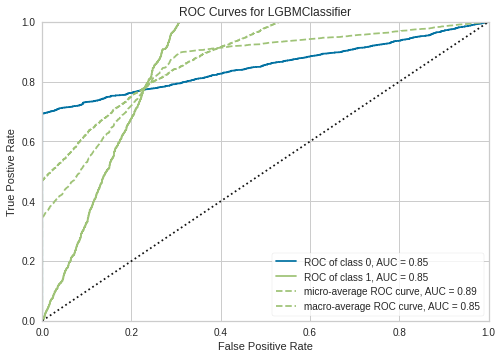

In [33]:
#plot ROC-AUC
plot_model(lgbm)

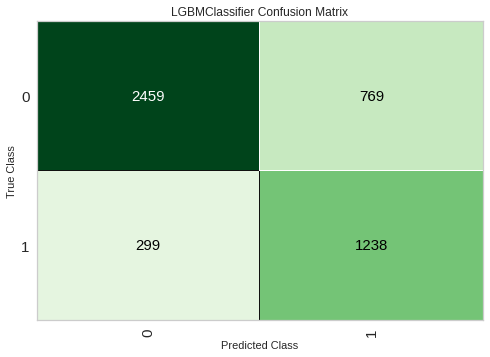

In [34]:
#plot Matriz de Confusão
plot_model(lgbm, plot = 'confusion_matrix')

In [35]:
def calcula_f1(tp, fp, fn):
  precisao = tp/(tp+fp)
  recall = tp/(tp+fn)
  return (2*((precisao*recall)/(precisao+recall)))

In [36]:
calcula_f1(2459,299,769)

0.8215836952890077

In [37]:
calcula_f1(1238,769,299)

0.698645598194131

In [39]:
calcula_f1(2459+1238, 299+769, 769+299)

0.775865687303253

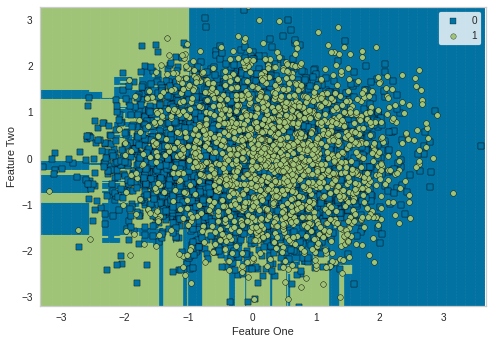

In [40]:
plot_model(lgbm, plot = 'boundary')

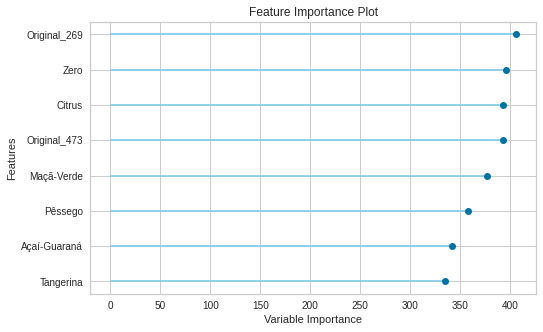

In [41]:
#melhores features
plot_model(lgbm, plot = 'feature')

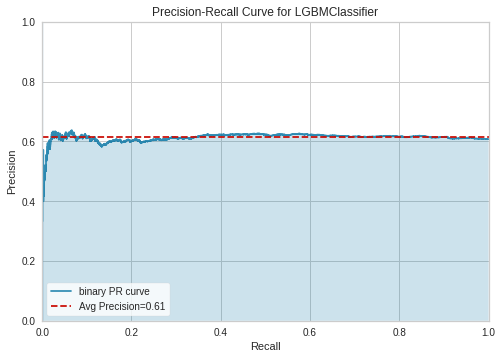

In [42]:
plot_model(lgbm, plot = 'pr')

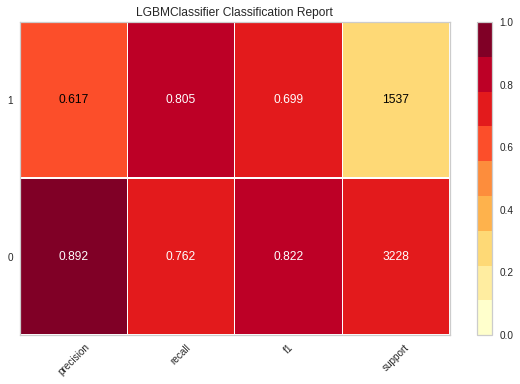

In [43]:
#report classificação
plot_model(lgbm, plot = 'class_report')

In [44]:
#avaliação completa do modelo
evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# 10. Interpret Model

In [47]:
!pip install shap

     |████████████████████████████████| 327kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456466 sha256=a1222ab99662b82d3298a51219482b1771d5a19279df1056a30d3e3801e6692e
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [45]:
catboost = create_model('catboost', cross_validation=False)

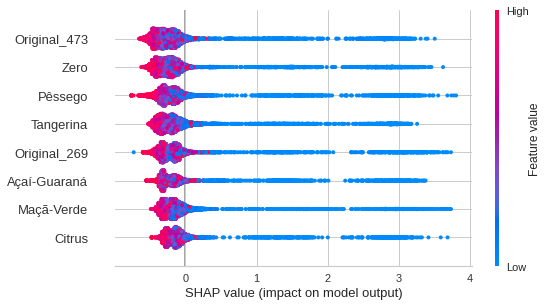

In [48]:
#nota mental: estudar SHAP value - Interpreta as features pelo SHAP
interpret_model(catboost)

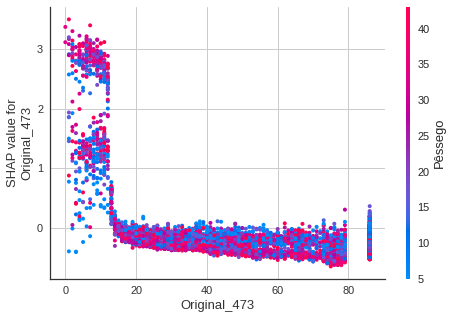

In [50]:
interpret_model(catboost, plot = 'correlation')

In [51]:
interpret_model(catboost, plot = 'reason', observation = 12)

# 11. AutoML()

In [53]:
best = automl(optimize = 'F1')
best

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.4, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=90, n_jobs=-1, num_leaves=10, objective=None,
               random_state=123, reg_alpha=0.9, reg_lambda=0.2, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# 12. Predict Model

In [55]:
pred_holdouts = predict_model(lgbm)
pred_holdouts.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7759,0.8515,0.8055,0.6168,0.6986,0.5252,0.537


,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET,Label,Score
0,13.0,28.0,9.0,17.0,15.0,9.0,10.0,8.0,0,1,0.6415
1,78.0,58.0,7.0,11.0,31.0,20.0,43.0,4.0,0,0,0.4512
2,21.0,54.0,57.0,25.0,7.0,24.0,29.0,25.0,0,0,0.0158
3,73.0,27.0,55.0,14.0,10.0,37.0,9.0,35.0,0,0,0.0143
4,60.0,9.0,7.0,10.0,33.0,6.0,20.0,22.0,1,1,0.6501


In [56]:
new_data = data.copy()
new_data.drop(['TARGET'], axis=1, inplace=True)
predict_new = predict_model(best, data=new_data)
predict_new.head()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,Label,Score
0,20,61,31,27,11,6,22,32,1,0.5237
1,63,44,60,41,34,43,22,14,0,0.0137
2,58,23,55,21,9,20,24,25,0,0.0152
3,7,20,5,30,43,27,15,39,1,0.7066
4,22,36,28,19,26,6,37,39,1,0.5573


# 13. Save / Load Model

In [57]:
save_model(best, model_name='best-model')

Transformation Pipeline and Model Succesfully Saved


In [58]:
loaded_bestmodel = load_model('best-model')
print(loaded_bestmodel)

Transformation Pipeline and Model Sucessfully Loaded
[Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='TARGET',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Lev...
                ('group', Empty()), ('nonliner', Empty()), ('scaling', Empty()),
                ('P_transform', Empty()), ('pt_target', Empty()),
                ('binn', Empty()), ('rem_outliers', Empty()),
                ('cluster_all', Empty()), ('dummy', Dummify(t

In [59]:
from sklearn import set_config
set_config(display='diagram')
loaded_bestmodel[0]

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='TARGET',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Lev...
                ('group', Empty()), ('nonliner', Empty()), ('scaling', Empty()),
                ('P_transform', Empty()), ('pt_target', Empty()),
                ('binn', Empty()), ('rem_outliers', Empty()),
                ('cluster_all', Empty()), ('dummy', Dummify(target='TARGET')),
                ('fix_perfect', Empty()), ('clean_names', Clean_Colum_Names()),
                ('feature_select', Empty()), ('fix_multi', Empty()),
                ('dfs', Empty()), ('pca', Empty())],
         verbose=False)

In [60]:
from sklearn import set_config
set_config(display='text')

# 14. Deploy Model

In [63]:
!pip install awscli

     |████████████████████████████████| 1.3MB 2.9MB/s 
     |████████████████████████████████| 6.6MB 14.9MB/s 
  Created wheel for awscli: filename=awscli-1.18.137-py2.py3-none-any.whl size=3325729 sha256=aecbe35dae610c1a07842e1ce900da0dfbb52455f916de6e0e401f6641f626e8
  Stored in directory: /root/.cache/pip/wheels/fc/32/5d/ab0a05ab060accbdc5a368549b5bbe3d21a17998c9f0c59437
Successfully built awscli
  Found existing installation: botocore 1.17.48
    Uninstalling botocore-1.17.48:
      Successfully uninstalled botocore-1.17.48
  Found existing installation: rsa 4.6
    Uninstalling rsa-4.6:
      Successfully uninstalled rsa-4.6


In [65]:
#precisa de credenciais no AWS
#deploy_model(best, model_name = 'best-aws', authentication = {'bucket' : 'pycaret-test'})

# 15. Get Config / Set Config

In [61]:
X_train.head()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
30544,57,10,12,21,41,34,5,26
4011,30,53,37,16,19,9,37,2
16041,37,41,15,5,19,24,40,13
13143,86,19,7,40,8,9,8,6
6407,86,65,65,43,43,43,43,43


In [66]:
get_config('seed')

123

In [67]:
from pycaret.classification import set_config
set_config('seed', 999)

In [68]:
get_config('seed')

999

# 16. MLFlow UI

In [71]:
#!mlflow ui

# End
Thank you. For more information / tutorials on PyCaret, please visit https://www.pycaret.org